In [1]:
#！/usr/bin/python
# -*- coding: utf-8 -*-

In [2]:
%matplotlib inline
import pyodbc
import textwrap
import pandas as pd

import powerlaw
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
sql = textwrap.dedent("""
    SELECT COUNT(url) AS Intensity
    FROM [data].[dbo].[health_records]
    GROUP BY userid, date
    ORDER BY userid, date
""")

In [4]:
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=localhost;DATABASE=data;')

cursor = cnxn.cursor()

In [5]:
rowsx=cursor.execute(sql).fetchall()

dfx = pd.DataFrame( [[ij for ij in i] for i in rowsx] )
dfx.rename(columns={0:'intensity'}, inplace=True)
# 剔除intensity小于3的情况
a=list(dfx.intensity)
b=set([1,2])
ret=list(set(a)^b)
dfx = dfx[dfx.intensity.isin(ret)]

In [6]:
def plotPowerlaw(data,ax,col,xlab):
    fit = powerlaw.Fit(data,xmin=1)
    fit.plot_pdf(color = col, linewidth = 2)
    fit = powerlaw.Fit(data)
    fit.power_law.plot_pdf(color = col, linestyle = 'dotted', ax = ax)
    a,x = (fit.power_law.alpha,fit.power_law.xmin)
    minx,maxx=ax.get_xlim()
    miny,maxy=ax.get_ylim()
    ax.text(minx*5,maxy/10,r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x), fontsize = 20)
    ax.set_xlabel(xlab, fontsize = 20)
    ax.set_ylabel('$P(k)$', fontsize = 20)
    return fit

Calculating best minimal value for power law fit


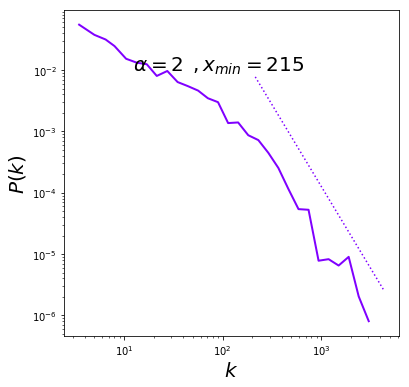

In [7]:
fig = plt.figure(figsize=(6, 6),facecolor='white')
cmap = cm.get_cmap('rainbow_r',6)

ax = fig.add_subplot(1,1,1)
fitted = plotPowerlaw(dfx.intensity,ax,cmap(6),'$k$')

In [8]:
fitted.alpha, fitted.D

(2.6655623774322788, 0.026467068004000338)

(0, 0.4)

Text(0.5,0,'$x_{min}$')

Text(0,0.5,'$D,\\sigma,\\alpha$')

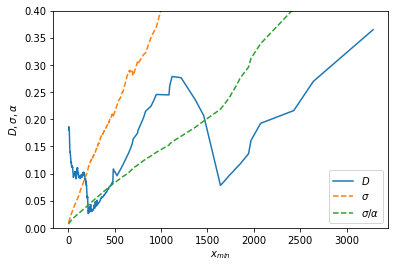

In [9]:
from matplotlib.pylab import plot
import pylab as pb

plot(fitted.xmins, fitted.Ds, label=r'$D$')
plot(fitted.xmins, fitted.sigmas, label=r'$\sigma$', linestyle='--')
plot(fitted.xmins, fitted.sigmas/fitted.alphas, label=r'$\sigma /\alpha$', linestyle='--')

pb.ylim(0, .4)
pb.legend(loc=4)
pb.xlabel(r'$x_{min}$')
pb.ylabel(r'$D,\sigma,\alpha$')

In [10]:
# fitted.supported_distributions

r1, p1 = fitted.distribution_compare('power_law', 'exponential', nested = True)
r2, p2 = fitted.distribution_compare('power_law', 'lognormal', nested = True)
r3, p3 = fitted.distribution_compare('power_law', 'truncated_power_law', nested = True)
r4, p4 = fitted.distribution_compare('power_law', 'stretched_exponential', nested = True)

print (r1, p1)
print (r2, p2)
print (r3, p3)
print (r4, p4)

Assuming nested distributions


42.565495445850914 0.0
-0.007561541125161497 0.9021261490401546
-0.2300839422861678 0.4975455225591846
0.5143853320359266 0.3104475782909928


Text(0,0.5,'p(X≥x)')

Text(0.5,0,'intensity')

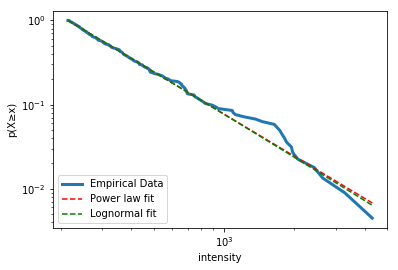

In [11]:
fig = fitted.plot_ccdf(linewidth=3, label='Empirical Data')
fitted.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fitted.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("intensity")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)